### G1 ResNet Ablation Study 

- 목표 
    - 직접 ResNet 구현하기 
    - 모델을 config에 따라서 변경가능하도록 만들기 
    - 직접 실험해서 성능 비교하기 

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

Duplicate key in file PosixPath('/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 401 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 1. 학습 데이터 확인

- TensorFlow Datasets에서 제공하는 Cats Vs Dogs 사용

In [4]:
import urllib3
urllib3.disable_warnings()

# cats_vs_dogs데이터에는 train과 test데이터가 나뉘어져 있지 않기 때문에 비율대로 임의로 나눠줌
ds_train, ds_info = tfds.load(
'cats_vs_dogs',
split='train[:80%]',
with_info=True,
)

ds_test, ds_info = tfds.load(
'cats_vs_dogs',
split='train[80%:]',
with_info=True,
)


In [26]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [27]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [28]:
def normalize_and_resize_img(image, label):
    
    # 이미지의 크기가 달라 일정하게 resize
    image = tf.image.resize(image, (224, 224))
    
    return tf.cast(image, tf.float32)/255., label

In [29]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds=ds.repeat()
        ds=ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds  

In [30]:
ds_info.features["label"].num_classes

2

In [31]:
ds_info.features['label'].names

['cat', 'dog']

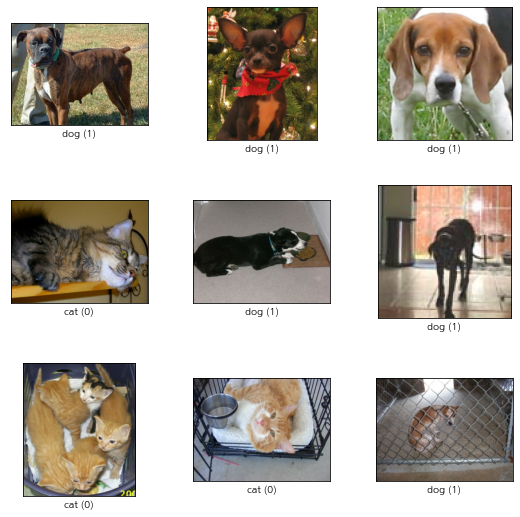

In [32]:
fig = tfds.show_examples(ds_train, ds_info)

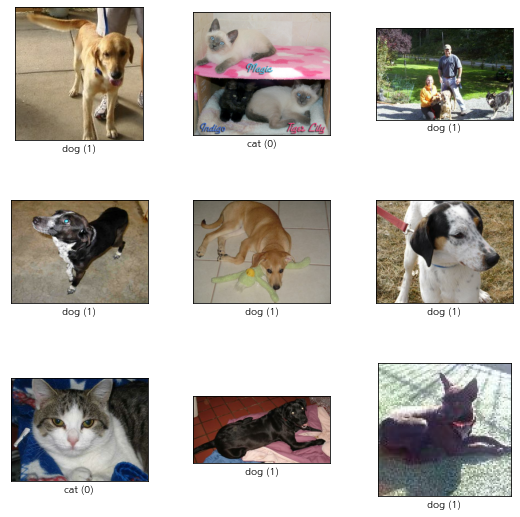

In [33]:
fig = tfds.show_examples(ds_test, ds_info)

#### 2. Resnet 기본 블록 구성하기

In [34]:
def build_resnet_block(input_layer ,num_cnn=2,stage_num=2, channel=64, is_50=False, is_plain=True):
    
    x = input_layer
    short = x
  
    if not is_50:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3, 3), 
                                        padding='same',
                                        strides=stride,
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)
                
                # plain 모델인 경우 short cut을 비활성
                if is_plain == False:
                    short = keras.layers.Conv2D(filters=channel,
                                                kernel_size=(1, 1),
                                                strides=stride,
                                                padding='same',
                                                name=f'stage{stage_num}_{cnn_num+1}_short',
                                                )(short)
                    short = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(short)
                    x = keras.layers.Add()([x, short])
                
                x = keras.layers.Activation('relu')(x)

                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)

                if is_plain == False:
                    x = keras.layers.Add()([x, short])

                x = keras.layers.Activation('relu')(x)

                short = x

    else:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                    
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        strides = stride,
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                if is_plain == False:
                    short = keras.layers.Conv2D(filters=channel*4,
                                                kernel_size=(1, 1),
                                                strides=stride,
                                                padding='same',
                                                name=f'stage{stage_num}_{cnn_num+1}_short',
                                                )(short)
                    short = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn4')(short)
                    x = keras.layers.Add()([x, short])
                x = keras.layers.Activation('relu')(x)
                
                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                if is_plain == False:
                    x = keras.layers.Add()([x, short])
                    
                x = keras.layers.Activation('relu')(x)
                
                short = x

                    
    return x
    

#### 3. ResNet-34, ResNet-50 Complete Model

In [35]:
def build_resnet(input_shape=(224, 224, 3), is_50=False, is_plain=True):
    
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 2
    
    
        
    input_layer = keras.layers.Input(shape=input_shape)

    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)

    x = keras.layers.BatchNormalization(name=f'batch_normalization_0')(x)
    x = keras.layers.Activation('relu', name=f'activation_0')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x)
    
    output = x 
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_resnet_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    is_50 = is_50,
                                    is_plain = is_plain,
                                    )

    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)

    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [36]:
resnet_34 = build_resnet(is_plain=False)
resnet_34_plain = build_resnet(is_plain=True)
resnet_50 = build_resnet(is_50=True, is_plain=False)
resnet_50_plain = build_resnet(is_50=True, is_plain=True)

In [37]:
resnet_34.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_0 (BatchNor (None, 112, 112, 64) 256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 112, 112, 64) 0           batch_normalization_0[0][0]      
_______________________________________________________________________________________

In [38]:
resnet_34_plain.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_0 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_0 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)      

In [39]:
resnet_50.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 112, 112, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_0 (BatchNor (None, 112, 112, 64) 256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 112, 112, 64) 0           batch_normalization_0[0][0]      
______________________________________________________________________________________

In [40]:
resnet_50_plain.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_0 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_0 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)      

#### 4. 모델 학습

In [41]:
BATCH_SIZE =16
EPOCH = 50

In [42]:
ds_train, ds_info = tfds.load(
'cats_vs_dogs',
split='train[:80%]',
as_supervised=True,
    with_info=True,
)

ds_test, ds_info = tfds.load(
'cats_vs_dogs',
split='train[80%:]',
as_supervised=True,
    with_info=True,
)


ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test= apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [43]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
   2/1163 [..............................] - ETA: 1:18 - loss: 86.0986 - accuracy: 0.3438WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0330s vs `on_train_batch_end` time: 0.0520s). Check your callbacks.


1163/1163 [==============================] - 94s 81ms/step - loss: 2.4708 - accuracy: 0.5111 - val_loss: 0.7296 - val_accuracy: 0.4931
Epoch 2/50
1163/1163 [==============================] - 93s 80ms/step - loss: 0.6947 - accuracy: 0.5162 - val_loss: 0.7591 - val_accuracy: 0.5015
Epoch 3/50
1163/1163 [==============================] - 93s 80ms/step - loss: 0.6899 - accuracy: 0.5257 - val_loss: 0.7024 - val_accuracy: 0.5306
Epoch 4/50
1163/1163 [==============================] - 93s 80ms/step - loss: 0.6885 - accuracy: 0.5233 - val_loss: 0.7071 - val_accuracy: 0.4938
Epoch 5/50
1163/1163 [==============================] - 93s 80ms/step - loss: 0.6860 - accuracy: 0.5312 - val_loss: 0.7045 - val_accuracy: 0.5330
Epoch 6/50
1163/1163 [==============================] - 93s 80ms/step - loss: 0.6848 - accuracy: 0.5282 - val_loss: 0.7040 - val_accuracy: 0.5326
Epoch 7/50
1163/1163 [==============================] - 93s 80ms/step - loss: 0.6812 - accuracy: 0.5469 - val_loss: 0.6976 - val_accura

In [44]:
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history_34_plain = resnet_34_plain.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
   2/1163 [..............................] - ETA: 1:11 - loss: 4.6335 - accuracy: 0.5625WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0285s vs `on_train_batch_end` time: 0.0478s). Check your callbacks.


1163/1163 [==============================] - 85s 73ms/step - loss: 1.5002 - accuracy: 0.5060 - val_loss: 0.6906 - val_accuracy: 0.4862
Epoch 2/50
1163/1163 [==============================] - 85s 73ms/step - loss: 0.6903 - accuracy: 0.5215 - val_loss: 0.6955 - val_accuracy: 0.4897
Epoch 3/50
1163/1163 [==============================] - 85s 73ms/step - loss: 0.6906 - accuracy: 0.5155 - val_loss: 0.6907 - val_accuracy: 0.4922
Epoch 4/50
1163/1163 [==============================] - 85s 73ms/step - loss: 0.6894 - accuracy: 0.5161 - val_loss: 0.6886 - val_accuracy: 0.5384
Epoch 5/50
1163/1163 [==============================] - 85s 73ms/step - loss: 0.6893 - accuracy: 0.5181 - val_loss: 0.6986 - val_accuracy: 0.4855
Epoch 6/50
1163/1163 [==============================] - 85s 73ms/step - loss: 0.6883 - accuracy: 0.5240 - val_loss: 0.7027 - val_accuracy: 0.4853
Epoch 7/50
1163/1163 [==============================] - 85s 73ms/step - loss: 0.6886 - accuracy: 0.5172 - val_loss: 0.6929 - val_accura

In [45]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 159s 137ms/step - loss: 7.4148 - accuracy: 0.5181 - val_loss: 0.6903 - val_accuracy: 0.5336
Epoch 2/50
1163/1163 [==============================] - 174s 149ms/step - loss: 0.6864 - accuracy: 0.5387 - val_loss: 0.7214 - val_accuracy: 0.5149
Epoch 3/50
1163/1163 [==============================] - 150s 129ms/step - loss: 0.6787 - accuracy: 0.5546 - val_loss: 0.6877 - val_accuracy: 0.5509
Epoch 4/50
1163/1163 [==============================] - 150s 129ms/step - loss: 0.6757 - accuracy: 0.5643 - val_loss: 0.6865 - val_accuracy: 0.5509
Epoch 5/50
1163/1163 [==============================] - 150s 129ms/step - loss: 0.6695 - accuracy: 0.5746 - val_loss: 0.6857 - val_accuracy: 0.5563
Epoch 6/50
1163/1163 [==============================] - 150s 129ms/step - loss: 0.6661 - accuracy: 0.5791 - val_loss: 0.6893 - val_accuracy: 0.5545
Epoch 7/50
1163/1163 [==============================] - 150s 129ms/step - loss: 0.6642 - accuracy: 0.5872 - val_

In [46]:
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history_50_plain = resnet_50_plain.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
   2/1163 [..............................] - ETA: 1:48 - loss: 3.7925 - accuracy: 0.5938WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0449s vs `on_train_batch_end` time: 0.0696s). Check your callbacks.


1163/1163 [==============================] - 125s 107ms/step - loss: 2.5100 - accuracy: 0.5029 - val_loss: 0.6936 - val_accuracy: 0.5078
Epoch 2/50
1163/1163 [==============================] - 124s 107ms/step - loss: 0.6939 - accuracy: 0.5084 - val_loss: 0.6933 - val_accuracy: 0.5093
Epoch 3/50
1163/1163 [==============================] - 124s 107ms/step - loss: 0.6956 - accuracy: 0.5098 - val_loss: 0.6943 - val_accuracy: 0.4985
Epoch 4/50
1163/1163 [==============================] - 124s 107ms/step - loss: 0.6931 - accuracy: 0.5120 - val_loss: 0.6916 - val_accuracy: 0.5104
Epoch 5/50
1163/1163 [==============================] - 125s 108ms/step - loss: 0.6933 - accuracy: 0.5087 - val_loss: 0.6933 - val_accuracy: 0.5039
Epoch 6/50
1163/1163 [==============================] - 127s 109ms/step - loss: 0.6937 - accuracy: 0.5078 - val_loss: 0.6923 - val_accuracy: 0.5162
Epoch 7/50
1163/1163 [==============================] - 127s 109ms/step - loss: 0.6928 - accuracy: 0.5124 - val_loss: 0.692

#### 5. 결과

- 학습 시간의 부족으로 충분한 Epochs를 학습하여보지는 못하였지만 유의미한 결과는 확인할 수 있다.

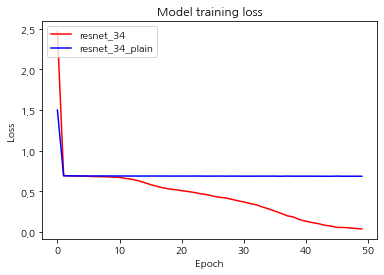

In [47]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_plain'], loc='upper left')
plt.show()

**ResNet34는 학습이 진행될수록 loss값이 꾸준히 줄어드는것에 반해 plain모델은 일정 loss에서 큰 변화가 없다**

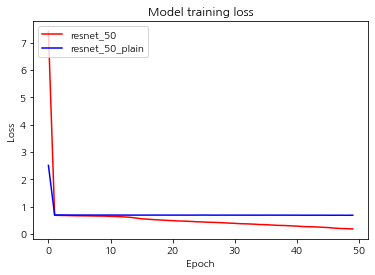

In [48]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_plain'], loc='upper left')
plt.show()

**- ResNet50모델에서도 ResNet34와 같이 plain모델에 비해 학습이 잘 진행되는 것을 확인할 수 있다**   
**- 이를 통해 논문에서 제시한 skip network를 통한 성능의 향상을 직접 확인할 수 있었다**

|모델|Epochs|validation accuracy|
|---|------|-------------|
|ResNet34|50|0.7865|
|ResNet34_plain|50|0.4782|
|ResNet50|50|0.7703|
|ResNet50_plain|50|0.5377|

#### 6. 고찰

- 간단한 구조이지만 논문의 모델을 직접 구현하여보면서 네트워크 구조를 이해하는데 많은 도움이 되었고 자신감을 얻을 수 있었다.
- 코드를 수정하면서 더 효율적인 방식이 어떤것이 있을지 고민하는 시간이 되었다. 
- config를 가지고 변경을 할 수 있도록 만들면서 처음부터 코드를 설계할 때 config에 따라 구조를 어떻게 잡아야 하는지 공부가 되었고 작업에서 반복되는 부분을 함수로 만드는 방법을 배울 수 있었다.